# Load data

In [1]:
from pandas import DataFrame, read_csv

def load_data(
        data_file: str,
        n_rows: int | None = None,
) -> DataFrame:
    return read_csv(data_file, index_col='row_index', nrows=n_rows)

In [2]:
import pandas as pd

# train_data = file_manager.load_training_data()

# TODO
train_file = 'X_train.csv'
test_file = 'X_test.csv'
n_rows = 100_000

test_data = load_data(test_file)
tiny_train_data = load_data(train_file, n_rows=n_rows)
# train_data = load_data(train_file)

# Split raw data by variable category (piezo, weather, ...)

We are only interested in training data.

In [3]:
from pandas import DataFrame

# Function to extract variable category
def extract_category(
        df: DataFrame,
        category: str,
) -> DataFrame:
    return df[df.columns[df.columns.str.startswith(category)]]

In [4]:
# Example with meteo variables
hydro_variables = extract_category(tiny_train_data, 'hydro')
hydro_variables.head()
hydro_variables["hydro_status_label"].unique()

array(['Donnée validée', 'Donnée pré-validée', 'Donnée brute',
       'Donnée corrigée'], dtype=object)

In [5]:
hydro_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 105170
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   hydro_station_code             100000 non-null  object 
 1   hydro_observation_date_elab    100000 non-null  object 
 2   hydro_observation_result_elab  100000 non-null  float64
 3   hydro_status_code              100000 non-null  int64  
 4   hydro_status_label             100000 non-null  object 
 5   hydro_method_code              100000 non-null  int64  
 6   hydro_method_label             100000 non-null  object 
 7   hydro_qualification_code       100000 non-null  int64  
 8   hydro_qualification_label      100000 non-null  object 
 9   hydro_longitude                100000 non-null  float64
 10  hydro_latitude                 100000 non-null  float64
 11  hydro_hydro_quantity_elab      100000 non-null  object 
dtypes: float64(3), int64(3), object(6)


# Hydrology Information

### 1.1. Unique values
Values with one unique values can be observed so we can drop them.

In [6]:
# Check number of different values
hydro_variables.nunique()

hydro_station_code                1110
hydro_observation_date_elab         41
hydro_observation_result_elab    19619
hydro_status_code                    4
hydro_status_label                   4
hydro_method_code                    1
hydro_method_label                   1
hydro_qualification_code             3
hydro_qualification_label            3
hydro_longitude                   1103
hydro_latitude                    1103
hydro_hydro_quantity_elab            2
dtype: int64

In [7]:
# Columns to drop
unique_columns = [
    "hydro_method_code",
    "hydro_method_label"
]

# Create the new DataFrame excluding the specified columns
hydro_variables = hydro_variables.drop(columns=unique_columns, errors='ignore')
hydro_variables.head()
hydro_variables["hydro_status_label"].unique()

array(['Donnée validée', 'Donnée pré-validée', 'Donnée brute',
       'Donnée corrigée'], dtype=object)

### 1.2. Introductory visualization

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(dataframe, numerical_columns, figsize=(12, 10)):
    correlation_matrix = dataframe[numerical_columns].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()
    return correlation_matrix

In [9]:
import numpy as np

def get_sorted_correlation_pairs(correlation_matrix):
    """
    Converts a correlation matrix into a sorted list of feature pairs based on correlation values.
    
    Parameters:
    - correlation_matrix: pandas.DataFrame, the correlation matrix to process.
    
    Returns:
    - pandas.DataFrame: A DataFrame containing sorted correlation pairs with absolute correlation values.
    """
    # Remove the lower triangle and diagonal
    correlation_matrix = correlation_matrix.where(
        ~np.tril(np.ones(correlation_matrix.shape)).astype(bool)
    )

    # Convert to long format
    correlation_pairs = correlation_matrix.stack().reset_index()
    correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation Score']
    correlation_pairs['Absolute Correlation'] = np.abs(correlation_pairs['Correlation Score'])

    # Sort by absolute correlation value
    sorted_correlation_pairs = correlation_pairs.sort_values(by='Absolute Correlation', ascending=False)

    return sorted_correlation_pairs

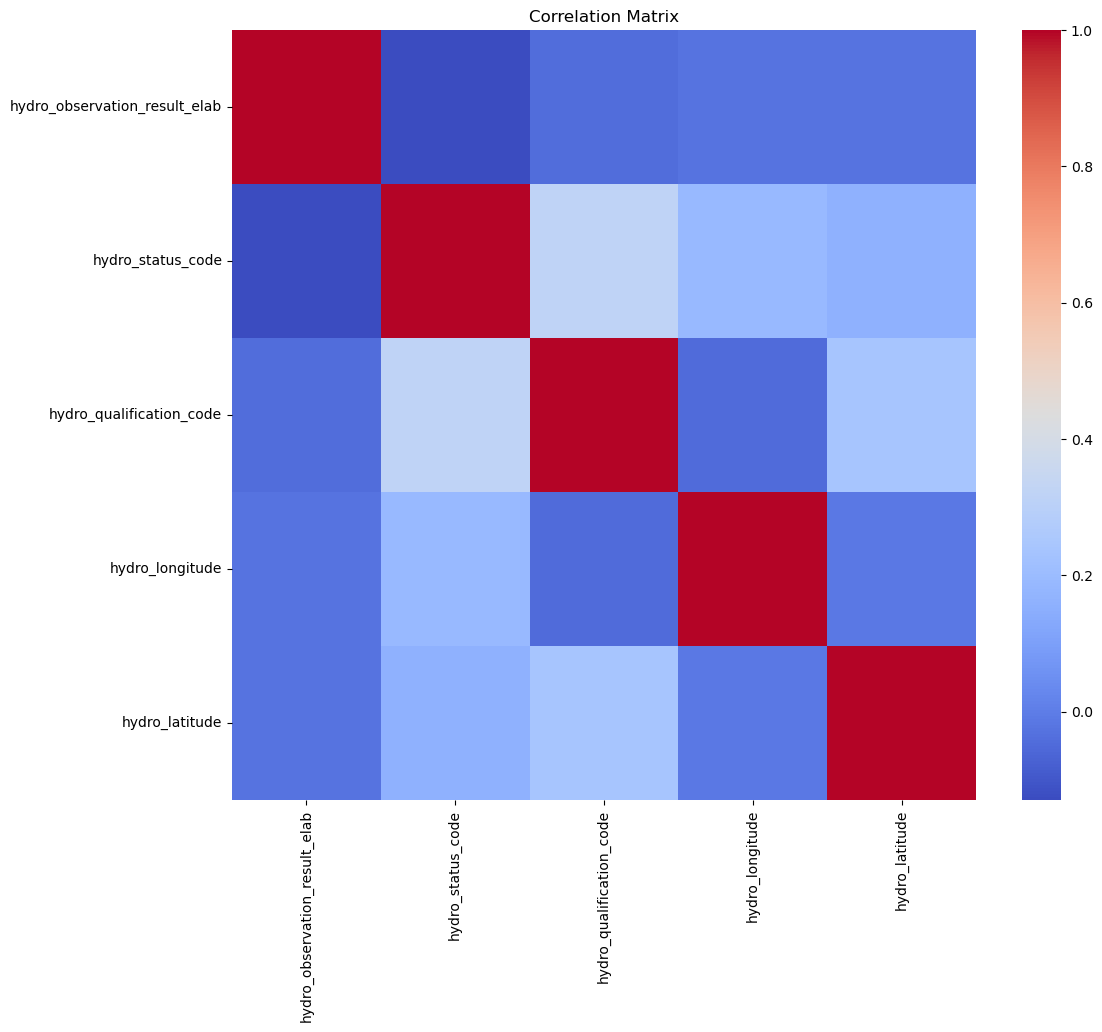

In [10]:
# listing all numerical values except price to have only the features
numerical_hydro = hydro_variables.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = plot_correlation_matrix(hydro_variables, numerical_hydro)

In [11]:
print(get_sorted_correlation_pairs(correlation_matrix))

                       Feature 1                 Feature 2  Correlation Score  \
4              hydro_status_code  hydro_qualification_code           0.319332   
8       hydro_qualification_code            hydro_latitude           0.238548   
5              hydro_status_code           hydro_longitude           0.189748   
6              hydro_status_code            hydro_latitude           0.159080   
0  hydro_observation_result_elab         hydro_status_code          -0.129789   
7       hydro_qualification_code           hydro_longitude          -0.049249   
1  hydro_observation_result_elab  hydro_qualification_code          -0.042818   
3  hydro_observation_result_elab            hydro_latitude          -0.025708   
2  hydro_observation_result_elab           hydro_longitude          -0.024040   
9                hydro_longitude            hydro_latitude          -0.014935   

   Absolute Correlation  
4              0.319332  
8              0.238548  
5              0.189748  
6   

In [12]:
# Columns to drop
useless_columns = [
    "hydro_station_code",
    "hydro_qualification_label",
    "hydro_hydro_quantity_elab"
]

# Create the new DataFrame excluding the specified columns
hydro_variables = hydro_variables.drop(columns=useless_columns, errors='ignore')
hydro_variables.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude
row_index,,,,,,,
0,2020-01-01,1833.0,16,Donnée validée,20,5.685831,45.874843
1,2020-01-01,93389.0,16,Donnée validée,20,5.336428,46.047082
2,2020-01-01,108237.0,16,Donnée validée,20,5.233492,45.906423
3,2020-01-01,305464.0,16,Donnée validée,12,5.964334,46.137641
4,2020-01-01,85.0,12,Donnée pré-validée,20,5.330754,46.143007


In [13]:
# Convert to datetime
from datetime import datetime

def days_since_start_of_2020(date_str):
    # Convertir la date en un objet datetime
    parsed_date = pd.to_datetime(date_str, format='%Y-%m-%d')
    
    # Fixer la date de référence (1er janvier 2022)
    ref_date = datetime(2020, 1, 1)
    
    # Calculer le delta entre la date et le 1er janvier 2022
    delta = parsed_date - ref_date
    
    # Retourner le nombre de jours écoulés
    return delta.days

hydro_variables['hydro_observation_date_elab'] = hydro_variables['hydro_observation_date_elab'].apply(days_since_start_of_2020)
# hydro_variables["hydro_observation_date_elab"] = pd.to_datetime(hydro_variables['hydro_observation_date_elab'], errors='coerce')
hydro_variables.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude
row_index,,,,,,,
0,0,1833.0,16,Donnée validée,20,5.685831,45.874843
1,0,93389.0,16,Donnée validée,20,5.336428,46.047082
2,0,108237.0,16,Donnée validée,20,5.233492,45.906423
3,0,305464.0,16,Donnée validée,12,5.964334,46.137641
4,0,85.0,12,Donnée pré-validée,20,5.330754,46.143007


In [14]:
mapping = {
    'Donnée validée': 1,
    'Donnée pré-validée': 2,
    'Donnée brute': 3,
    'Donnée corrigée': 4
}

# Apply the mapping to the column
hydro_variables['hydro_status_label'] = hydro_variables['hydro_status_label'].map(mapping)
hydro_variables.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude
row_index,,,,,,,
0,0,1833.0,16,1,20,5.685831,45.874843
1,0,93389.0,16,1,20,5.336428,46.047082
2,0,108237.0,16,1,20,5.233492,45.906423
3,0,305464.0,16,1,12,5.964334,46.137641
4,0,85.0,12,2,20,5.330754,46.143007
